In [1]:
import FlexPlan; const _FP = FlexPlan
import PowerModelsACDC; const _PMACDC = PowerModelsACDC
import PowerModels; const _PM = PowerModels
import InfrastructureModels; const _IM = InfrastructureModels

import JuMP
import Cbc

┌ Info: Precompiling FlexPlan [196f2941-2d58-45ba-9f13-43a2532b2fa8]
└ @ Base loading.jl:1260
┌ Warning: Package FlexPlan does not have DataStructures in its dependencies:
│ - If you have FlexPlan checked out for development and have
│   added DataStructures as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with FlexPlan
└ Loading DataStructures into FlexPlan from project dependency, future warnings for FlexPlan are suppressed.


Solver configurations:

In [2]:
cbc = JuMP.with_optimizer(Cbc.Optimizer, tol=1e-4, print_level=0)

┌ Warning: `with_optimizer` is deprecated. Adapt the following example to update your code:
│ `with_optimizer(Ipopt.Optimizer, max_cpu_time=60.0)` becomes `optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0)`.
│   caller = ip:0x0
└ @ Core :-1


MathOptInterface.OptimizerWithAttributes(Cbc.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute,Any}[MathOptInterface.RawParameter("tol") => 0.0001, MathOptInterface.RawParameter("print_level") => 0])

Input parameters:

In [6]:
number_of_hours = 60 # Number of time points
file = "./test/data/case6_reliability.m"  #Input case, in matpower m-file format: Here 6bus case with candidate AC, DC lines and candidate storage

"./test/data/case6_reliability.m"

Define contingency scenarios:

In [4]:
scenario = Dict{String, Any}("hours" => number_of_hours, "contingency" => Dict{String, Any}())
# Base scenario
scenario["contingency"]["0"] = Dict{String, Any}()
scenario["contingency"]["0"]["year"] = 2019
scenario["contingency"]["0"]["start"] = 1546300800000   # 01.01.2019:00:00 in epoch time
scenario["contingency"]["0"]["probability"] = 0.98
scenario["contingency"]["0"]["faults"] = Dict()
# Contingency 1
scenario["contingency"]["1"] = Dict{String, Any}()
scenario["contingency"]["1"]["year"] = 2019
scenario["contingency"]["1"]["start"] = 1546300800000   # 01.01.2019:00:00 in epoch time
scenario["contingency"]["1"]["probability"] = 0.01
scenario["contingency"]["1"]["faults"] = Dict("branchdc" => [1])  
# Contingency 2
scenario["contingency"]["2"] = Dict{String, Any}()
scenario["contingency"]["2"]["year"] = 2019
scenario["contingency"]["2"]["start"] = 1546300800000 # 01.01.2019:00:00 in epoch time 
scenario["contingency"]["2"]["probability"] = 0.01
scenario["contingency"]["2"]["faults"] = Dict("branchdc_ne" => [3])
# Contingency 3
scenario["contingency"]["3"] = Dict{String, Any}()
scenario["contingency"]["3"]["year"] = 2019
scenario["contingency"]["3"]["start"] = 1546300800000 # 01.01.2019:00:00 in epoch time
scenario["contingency"]["3"]["probability"] = 0.01
scenario["contingency"]["3"]["faults"] = Dict("branchdc" => [2])
# Common parameters for all scenarios
scenario["utypes"] = [ "branchdc", "branchdc_ne"] # type of lines considered in contingencies
scenario["planning_horizon"] = 1 # in years, to scale generation cost  

1

# Define and modify input-data

Load system data from file:

In [7]:
data = _PM.parse_file(file) # Create PowerModels data dictionary (AC networks and storage)

[info | PowerModels]: extending matpower format with data: storage_extra 1x4
[info | PowerModels]: extending matpower format with data: convdc 4x35
[info | PowerModels]: extending matpower format with data: busdc 4x9
[info | PowerModels]: extending matpower format with data: convdc_ne 6x37
[info | PowerModels]: extending matpower format with data: ne_storage 1x25
[info | PowerModels]: extending matpower format with data: busdc_ne 4x9
[info | PowerModels]: extending matpower format with data: load_extra 5x19
[info | PowerModels]: extending matpower format with data: branchdc_ne 3x12
[info | PowerModels]: extending matpower format with data: ne_branch 2x15
[info | PowerModels]: extending matpower format with data: branchdc 2x10
[info | PowerModels]: extending matpower format with constant data: time_elapsed
[info | PowerModels]: extending matpower format by appending matrix "storage_extra" in to "storage"
[warn | PowerModels]: the voltage setpoint on generator 2 does not match the value 

Dict{String,Any} with 23 entries:
  "ne_branch"      => Dict{String,Any}("1"=>Dict{String,Any}("br_r"=>0.02,"rate…
  "time_elapsed"   => 1.0
  "branchdc_ne"    => Dict{String,Any}("1"=>Dict{String,Any}("c"=>0.0,"r"=>0.01…
  "bus"            => Dict{String,Any}("4"=>Dict{String,Any}("zone"=>1,"bus_i"=…
  "source_type"    => "matpower"
  "name"           => "case6"
  "dcline"         => Dict{String,Any}()
  "source_version" => "2"
  "gen"            => Dict{String,Any}("4"=>Dict{String,Any}("ncost"=>2,"qc1max…
  "branch"         => Dict{String,Any}("4"=>Dict{String,Any}("br_r"=>0.04,"rate…
  "storage"        => Dict{String,Any}("1"=>Dict{String,Any}("energy_rating"=>1…
  "switch"         => Dict{String,Any}()
  "baseMVA"        => 100.0
  "convdc"         => Dict{String,Any}("4"=>Dict{String,Any}("dVdcset"=>0,"Vtar…
  "load_extra"     => Dict{String,Any}("4"=>Dict{String,Any}("e_nce_max"=>0,"p_…
  "per_unit"       => true
  "ne_storage"     => Dict{String,Any}("1"=>Dict{String,Any}("ener

Create data for the contingency model based on system data and contingency scenarios:

In [8]:

data, contingency_profile, loadprofile, genprofile = _FP.create_contingency_data_italy(data, scenario) # create load and generation profiles
_PMACDC.process_additional_data!(data) # Add DC grid data to the data dictionary
_FP.add_storage_data!(data) # Add addtional storage data model
_FP.add_flexible_demand_data!(data) # Add flexible data model
_FP.scale_cost_data!(data, scenario) # Scale cost data



┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = read at CSV.jl:40 [inlined]
└ @ Core C:\Users\espenb\.julia\packages\CSV\MKemC\src\CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = read at CSV.jl:40 [inlined]
└ @ Core C:\Users\espenb\.julia\packages\CSV\MKemC\src\CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = read at CSV.jl:40 [inlined]
└ @ Core C:\Users\espenb\.julia\packages\CSV\MKemC\src\CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = read at CSV.jl:40 [inlined]
└ @ Core C:\Users\espenb\.julia\packages\CSV\MKemC\src\CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│

Translate data profiles into model parameters:

In [9]:
dim = number_of_hours * length(data["contingency"])
extradata = _FP.create_contingency_data(dim, data, contingency_profile, loadprofile, genprofile) # create a dictionary to pass time series 

Dict{String,Any} with 5 entries:
  "gen"         => Dict{String,Any}("4"=>Dict{String,Any}("pmax"=>[1.2 1.2 … 1.…
  "dim"         => 240
  "branchdc_ne" => Dict{String,Any}("1"=>Dict{String,Any}("status"=>[1.0 1.0 … …
  "load"        => Dict{String,Any}("4"=>Dict{String,Any}("pd"=>[0.844133 0.830…
  "branchdc"    => Dict{String,Any}("1"=>Dict{String,Any}("status"=>[1.0 1.0 … …

Create data dictionary where time series data is included at the right place

In [10]:
mn_data = _PMACDC.multinetwork_data(data, extradata, Set{String}(["source_type", "contingency", "contingency_prob", "name", "source_version", "per_unit"]))

Dict{String,Any} with 8 entries:
  "name"             => "240 replicates of case6"
  "contingency"      => Dict{String,Any}("1"=>Dict{Any,Any}("32"=>92,"29"=>89,"…
  "source_version"   => "2"
  "contingency_prob" => Dict{String,Any}("1"=>0.01,"0"=>0.98,"2"=>0.01,"3"=>0.0…
  "multinetwork"     => true
  "nw"               => Dict{String,Any}("1"=>Dict{String,Any}("ne_branch"=>Dic…
  "per_unit"         => true
  "source_type"      => "matpower"

# Create and solve optimization model

 Add PowerModels(ACDC) settings

In [11]:
s = Dict("output" => Dict("branch_flows" => true), "conv_losses_mp" => false, "process_data_internally" => false)

Dict{String,Any} with 3 entries:
  "conv_losses_mp"          => false
  "output"                  => Dict{String,Bool}("branch_flows"=>1)
  "process_data_internally" => false

Build optimisation model, solve it and write solution dictionary:

In [12]:
result = _FP.reliability_tnep(mn_data, _PM.DCPPowerModel, cbc, multinetwork=true; setting = s)

r converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 1 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: no reference DC bus found, setting reference bus based on AC bus type
[warn | PowerModels]: For converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 

Dict{String,Any} with 8 entries:
  "solve_time"         => 156.787
  "optimizer"          => "COIN Branch-and-Cut (Cbc)"
  "termination_status" => OPTIMAL
  "dual_status"        => NO_SOLUTION
  "primal_status"      => FEASIBLE_POINT
  "objective"          => 62518.9
  "solution"           => Dict{String,Any}("multinetwork"=>true,"nw"=>Dict{Stri…
  "objective_lb"       => 62518.9

Continuous objective value is 62236.5 - 15.73 seconds
Cgl0002I 960 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 4755 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 240 strengthened rows, 0 substitutions
Cgl0004I processed model has 47224 rows, 23916 columns (12 integer (12 of which binary)) and 129961 elements
Cbc0045I Trying just fixing integer variables (and fixingish SOS).
Cbc0045I MIPStart provided solution with cost 759278
Cbc0012I Integer solution of 759277.94 found by Reduced search after 0 iterations and 0 nodes (31.51 seconds)
Cbc0031I 650 added rows had average density of 5.9753846
Cbc0013I At root node, 650 cuts changed objective from 62236.767 to 62376.291 in 12 passes
Cbc0014I Cut generator 0 (Probing) - 567 row cuts average 3.6 elements, 0 column cuts (572 active)  in 0.127 seconds - new frequency is 1
Cbc0014I Cut generator 1 (Gomory) - 23 row cuts average 48.4 elements, 0 column cuts (0 active)  in 0.180 seconds - new frequency is -100

# Plot and examine results

<img src="./images/test_system.png"/>

Plot energy balance for bus nr. 5

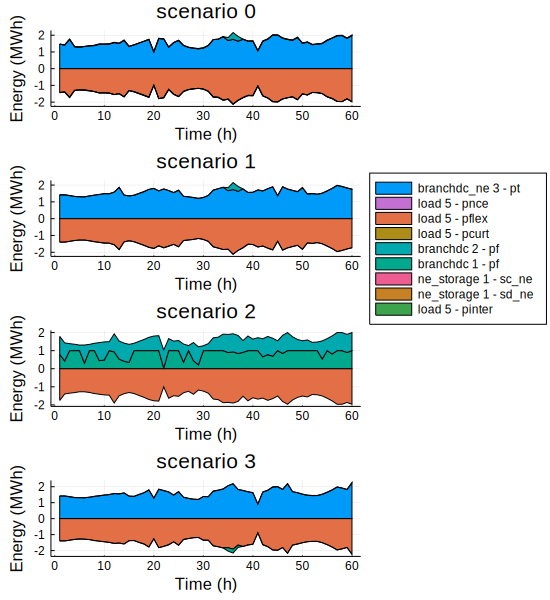

UndefVarError: UndefVarError: savefig not defined

In [13]:
enbal_plot = _FP.plot_energy_balance_scenarios(data, result, "contingency", 5)
savefig(enbal_plot, "bus5_enbal.png")

In [6]:
display(enbal_plot)

UndefVarError: UndefVarError: enbal_plot not defined